In [1]:
from IPython.display import HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
import scipy.spatial
from sportvu.sportvu_helper import *
from datetime import datetime
from scipy.interpolate import interp1d
plt.style.use('seaborn-pastel')

%matplotlib inline

In [2]:
game = load_game_data("0021500001")

In [4]:
def assign_rebound(play, player_idx):
    """
    Find the rebound frame for a particular player.  Ad-hoc, assigns it as the first time
    that the ball is closest to the given player.
    
    Parameters
    ----------
    play: pd.DataFrame
        The selected event
    player_idx: int
        The index of the player to track
    """
    min_dist = np.inf
    frame = None
    times = play['game_clock'].unique()
    for t in times:
        snapshot = play[play['game_clock'] == t]
        if len(snapshot) == 11:
            ball_pos = snapshot[snapshot['player_id'] == -1][['x_loc','y_loc']].values
            player_pos = snapshot[snapshot['player_id'] != -1][['x_loc','y_loc']].values
            dist_vals = scipy.spatial.distance.cdist(ball_pos.reshape(1,2), player_pos)[0]
            if dist_vals[player_idx] < min_dist:
                min_dist = dist_vals[player_idx]
                frame = snapshot
    return min_dist, frame
        

def find_event_position(game, event_id):
    event = game.event_data[game.event_data['EVENTNUM'] == event_id] 
    player_id = event["PLAYER1_ID"].values[0]
    
    play = game.tracking_data[game.tracking_data['event_id'] == event_id]
    player_ids = np.array(play['player_id'].unique())
    player_idx = np.where(player_ids == player_id)[0] - 1
    if len(player_idx) == 0:
        return None, None, None
        
    t = event['game_clock'].values[0]
    play['game_clock_round'] = play['game_clock'].round().astype(int)
    play = play[(play['game_clock_round'] >= t - 3) & (play['game_clock_round'] <= t + 3)]
    
    min_dist, frame = assign_rebound(play, player_idx)
    return min_dist, frame, player_idx

In [5]:
misses = game.event_data[game.event_data['EVENTMSGTYPE'] == 2]
misses["HOMEDESCRIPTION"].fillna(value = "", inplace = True)
misses["VISITORDESCRIPTION"].fillna(value = "",inplace = True)
missed_threes_home = misses[misses["HOMEDESCRIPTION"].str.contains("3PT")]
missed_threes_away = misses[misses["VISITORDESCRIPTION"].str.contains("3PT")]

/home/rmjiang/Basketball/analysis/lib/python3.6/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [6]:
three_shots_home = missed_threes_home['EVENTNUM'].values.astype(int)
three_shots_away = missed_threes_away['EVENTNUM'].values.astype(int)

In [7]:
mx = interp1d([-4.75,42.5],[0,47])
my = interp1d([-25, 25], [0, 50])
convert_y_to_x = lambda y: mx(y/10)
convert_x_to_y = lambda x: my(x/10)

shot_dists = []
rebound_dists = []
dists = []
frames = []
player_idxs = []
missed_threes = []
for i in range(three_shots_home.shape[0]):
    # rebounding events
    md_r, f_r, pr = find_event_position(game, three_shots_home[i] + 1)
    if md_r is not None:
        dists.append(md_r[0])
        frames.append(f_r)
        player_idxs.append(pr)

        # 3pt misses
        ball_pos = f_r[f_r['team_id'] == -1][['x_loc','y_loc']].values[0]
        s_shot = game.shot_data[game.shot_data['GAME_EVENT_ID'] == three_shots_home[i]]
        shot_pos = [s_shot['LOC_Y'].values[0], s_shot['LOC_X'].values[0]]
        if s_shot['PERIOD'].values[0] == 3 or s_shot['PERIOD'].values[0] == 4:
            shot_dists.append(scipy.spatial.distance.euclidean(shot_pos, np.array([94 - 4,25])))
            rebound_dists.append(scipy.spatial.distance.euclidean(ball_pos, np.array([94 - 4,25])))
        else:
            shot_dists.append(scipy.spatial.distance.euclidean(shot_pos, np.array([4, 25])))
            rebound_dists.append(scipy.spatial.distance.euclidean(ball_pos, np.array([4, 25])))
        missed_threes.append(shot_pos)
    
for i in range(three_shots_away.shape[0]):
    # rebounding events
    md_r, f_r, pr = find_event_position(game, three_shots_away[i] + 1)
    if md_r is not None:
        dists.append(md_r[0])
        frames.append(f_r)
        player_idxs.append(pr)

        # 3pt misses
        ball_pos = f_r[f_r['team_id'] == -1][['x_loc','y_loc']].values[0]
        s_shot = game.shot_data[game.shot_data['GAME_EVENT_ID'] == three_shots_away[i]]
        shot_pos = [s_shot['LOC_Y'].values[0], s_shot['LOC_X'].values[0]]
        if s_shot['PERIOD'].values[0] == 1 or s_shot['PERIOD'].values[0] == 2:
            shot_pos[0] = 94 - shot_pos[0]
            shot_dists.append(scipy.spatial.distance.euclidean(shot_pos, np.array([94 - 4,25])))
            rebound_dists.append(scipy.spatial.distance.euclidean(ball_pos, np.array([94 - 4,25])))
        else:
            shot_dists.append(scipy.spatial.distance.euclidean(shot_pos, np.array([4, 25])))
            rebound_dists.append(scipy.spatial.distance.euclidean(ball_pos, np.array([4, 25])))
        missed_threes.append(shot_pos)
    

/home/rmjiang/Basketball/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


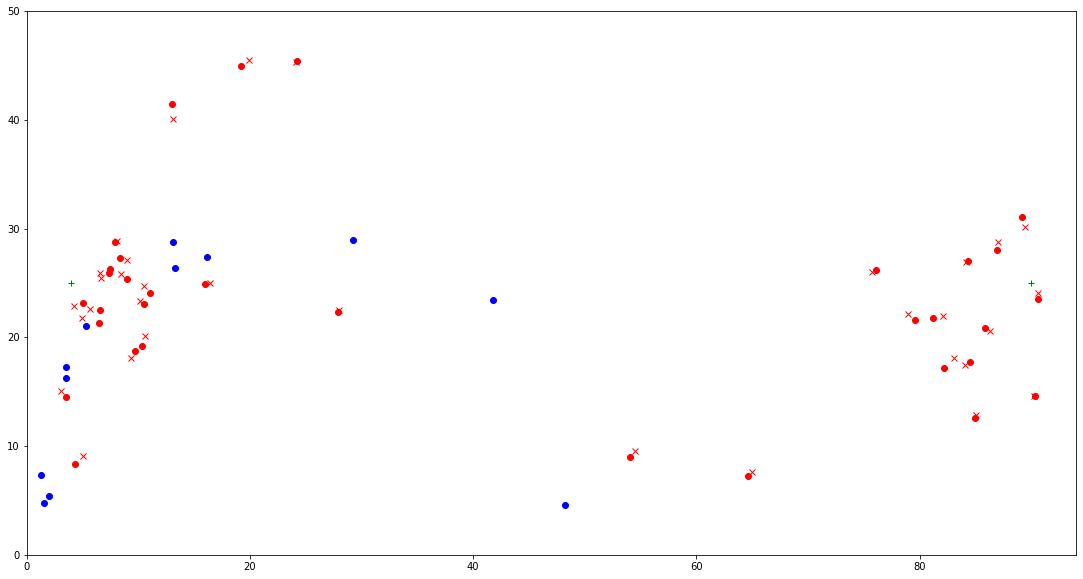

In [8]:
fig, ax = plt.subplots()
for i in range(len(missed_threes)):
    player_idx = player_idxs[i]
    f = frames[i][frames[i]['team_id'] == -1]
    player_pos = frames[i][frames[i]['player_id'] != -1][['x_loc','y_loc']].values
    ax.plot(player_pos[player_idx,0], player_pos[player_idx,1], marker = 'o', linestyle = 'None', color = 'r')
    ax.plot(missed_threes[i][0], missed_threes[i][1], marker = 'o', linestyle = 'None', color = 'b')
    ax.plot(f['x_loc'].values[0], f['y_loc'].values[0], marker = 'x', linestyle = 'None', color = 'r')
ax.plot(4, 25, marker = '+', linestyle = 'None', color = 'g')
ax.plot(94 - 4, 25, marker = '+', linestyle = 'None', color = 'g')
ax.set_xlim([0, 94])
ax.set_ylim([0, 50])
fig.set_size_inches(10 * 1.88,10)